## Finding Patterns

https://pythonprogramming.net/finding-forex-algo-patterns/

In [1]:
import time
import zipfile
import shutil
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from functools import reduce
from matplotlib import style
from IPython.display import display
style.use("ggplot")

In [2]:
# unzip data
with zipfile.ZipFile('GBPUSD.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [3]:
df = pd.read_csv('data/GBPUSD1d.txt', header=None, names=['date', 'bid', 'ask'])
df["date"] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S')

In [4]:
def percentChange(startPoint,currentPoint):
    return ((currentPoint-startPoint)/startPoint)*100.00

In [5]:
%%time
def patternFinder():
    '''
    The goal of patternFinder is to begin collection of %change patterns
    in the tick data. From there, we also collect the short-term outcome
    of this pattern. Later on, the length of the pattern, how far out we
    look to compare to, and the length of the compared range be changed,
    and even THAT can be machine learned to find the best of all 3 by
    comparing success rates.
    '''
    
    #Simple Average
    avgLine = ((df.bid+df.ask)/2)
    
    #This finds the length of the total array for us
    x = len(avgLine)-30
    #This will be our starting point, allowing us to compare to the
    #past 10 % changes. 
    y = 11
    # where we are in a trade. #
    # can be none, buy,
    currentStance = 'none'
    while y < x:
        
        p1 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-9])
        p2 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-8])
        p3 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-7])
        p4 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-6])
        p5 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-5])
        p6 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-4])
        p7 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-3])
        p8 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-2])
        p9 = percentChange(avgLine.iloc[y-10], avgLine.iloc[y-1])
        p10= percentChange(avgLine.iloc[y-10], avgLine.iloc[y])

        outcomeRange = avgLine.iloc[y+20:y+30]
        currentPoint = avgLine.iloc[y]

        if y < 20:
            #function to account for the average of the items in the array
            print(reduce(lambda x, y: x + y, outcomeRange) / len(outcomeRange))


            print(currentPoint)
            print('_______')
            print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10)
            print()
        
        y+=1

patternFinder()

1.553601
1.553555
_______
-0.001930961683282023 -0.0032182694721319405 -0.0032182694721319405 -0.0035400964193622853 -0.003861923366564046 -0.005471058102644308 -0.0061147119970621205 -0.00450557726099615 -0.00450557726099615 -0.004827404208212203

1.553593
1.553555
_______
-0.001287332646750063 -0.001287332646750063 -0.001609165808455444 -0.0019309989701322406 -0.003540164778587685 -0.00418383110195557 -0.0025746652935144184 -0.0025746652935144184 -0.002896498455205507 -0.002896498455205507

1.5535839999999999
1.5535299999999999
_______
0.0 -0.00032183730482207546 -0.000643674609615566 -0.0022528611336544812 -0.0028965357432557547 -0.001287349219231132 -0.001287349219231132 -0.0016091865240389152 -0.0016091865240389152 -0.0032183730480778304

1.5535714999999999
1.5535299999999999
_______
-0.00032183730482207546 -0.000643674609615566 -0.0022528611336544812 -0.0028965357432557547 -0.001287349219231132 -0.001287349219231132 -0.0016091865240389152 -0.0016091865240389152 -0.003218373048077

In [6]:
%%time
'''
Optimize with pandas vectorized operations
'''
def patternFinder2():
    '''
    The goal of patternFinder is to begin collection of %change patterns
    in the tick data. From there, we also collect the short-term outcome
    of this pattern. Later on, the length of the pattern, how far out we
    look to compare to, and the length of the compared range be changed,
    and even THAT can be machine learned to find the best of all 3 by
    comparing success rates.
    '''
    
    #Simple Average
    avgLine = pd.DataFrame((df.bid+df.ask)/2, columns=['current'])
    
    # prepare prev 1~10 days price for calculating percent change
    avgLine['prev10'] = avgLine['current'].shift(10)
    avgLine['prev9'] = avgLine['current'].shift(9)
    avgLine['prev8'] = avgLine['current'].shift(8)
    avgLine['prev7'] = avgLine['current'].shift(7)
    avgLine['prev6'] = avgLine['current'].shift(6)
    avgLine['prev5'] = avgLine['current'].shift(5)
    avgLine['prev4'] = avgLine['current'].shift(4)
    avgLine['prev3'] = avgLine['current'].shift(3)
    avgLine['prev2'] = avgLine['current'].shift(2)
    avgLine['prev1'] = avgLine['current'].shift(1)
    
    #This finds the length of the total array for us
    x = len(avgLine)-30
    #This will be our starting point, allowing us to compare to the
    #past 10 % changes. 
    y = 11
    # where we are in a trade. #
    # can be none, buy,
    currentStance = 'none'
    
    output = pd.DataFrame(avgLine['current'])
    
    #function to account for the average of the items in the array
    output['outcome'] = output['current'].rolling(window=10).mean().shift(-(40-y))
    
    output['p1'] = percentChange(avgLine['prev10'], avgLine['prev9'])
    output['p2'] = percentChange(avgLine['prev10'], avgLine['prev8'])
    output['p3'] = percentChange(avgLine['prev10'], avgLine['prev7'])
    output['p4'] = percentChange(avgLine['prev10'], avgLine['prev6'])
    output['p5'] = percentChange(avgLine['prev10'], avgLine['prev5'])
    output['p6'] = percentChange(avgLine['prev10'], avgLine['prev4'])
    output['p7'] = percentChange(avgLine['prev10'], avgLine['prev3'])
    output['p8'] = percentChange(avgLine['prev10'], avgLine['prev2'])
    output['p9'] = percentChange(avgLine['prev10'], avgLine['prev1'])
    output['p10'] = percentChange(avgLine['prev10'], avgLine['current'])
    
    display(output.iloc[y:20])

patternFinder2()

,current,outcome,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
11,1.553555,1.553601,-0.001931,-0.003218,-0.003218,-0.003540,-0.003862,-0.005471,-0.006115,-0.004506,-0.004506,-0.004827
12,1.553555,1.553593,-0.001287,-0.001287,-0.001609,-0.001931,-0.003540,-0.004184,-0.002575,-0.002575,-0.002896,-0.002896
13,1.553530,1.553584,0.000000,-0.000322,-0.000644,-0.002253,-0.002897,-0.001287,-0.001287,-0.001609,-0.001609,-0.003218
14,1.553530,1.553571,-0.000322,-0.000644,-0.002253,-0.002897,-0.001287,-0.001287,-0.001609,-0.001609,-0.003218,-0.003218
15,1.553540,1.553563,-0.000322,-0.001931,-0.002575,-0.000966,-0.000966,-0.001287,-0.001287,-0.002897,-0.002897,-0.002253
16,1.553540,1.553551,-0.001609,-0.002253,-0.000644,-0.000644,-0.000966,-0.000966,-0.002575,-0.002575,-0.001931,-0.001931
17,1.553535,1.553539,-0.000644,0.000966,0.000966,0.000644,0.000644,-0.000966,-0.000966,-0.000322,-0.000322,-0.000644
18,1.553520,1.553536,0.001609,0.001609,0.001287,0.001287,-0.000322,-0.000322,0.000322,0.000322,0.000000,-0.000966
19,1.553525,1.553535,0.000000,-0.000322,-0.000322,-0.001931,-0.001931,-0.001287,-0.001287,-0.001609,-0.002575,-0.002253


CPU times: user 11.3 ms, sys: 3.82 ms, total: 15.1 ms
Wall time: 14.4 ms


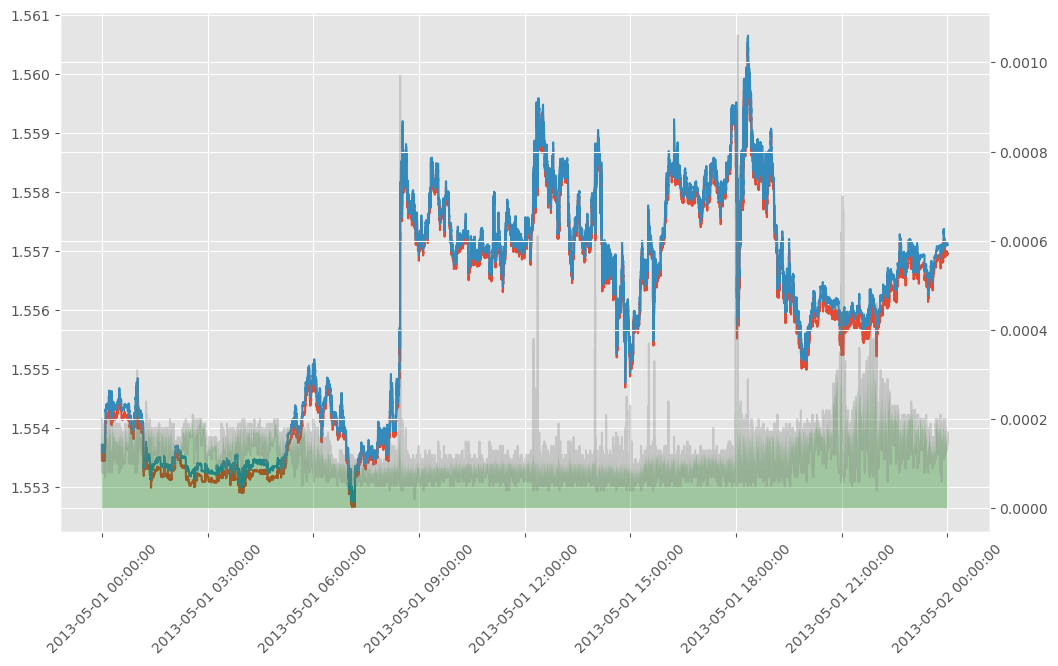

In [7]:
def graphRawFX():

    fig=plt.figure(figsize=(12,8))

    ax1 = plt.subplot2grid((40,40), (0,0), rowspan=40, colspan=40)
    ax1.plot(df.date, df.bid)
    ax1.plot(df.date, df.ask)

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

    #####
    plt.grid(True)
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

    #######
    ax1_2 = ax1.twinx()
    
    ax1_2.plot(df.date, (df.ask-df.bid), color='gray', alpha=.3)
    
    ax1_2.fill_between(df.date, 0, (df.ask-df.bid), facecolor='g',alpha=.3)
    
    #ax1_2.set_ylim(0, 3*df.ask.max())
    #######
    
    plt.subplots_adjust(bottom=.23)
    #plt.grid(True)
    
    plt.show()

graphRawFX()

In [8]:
# remove extracted data
shutil.rmtree('data')